#Qualité et préparation de donnée: détection des doublons

L'objectif de ce projet est de détecter les enregistrements qui représentent la même personne. L'output attendu doit être une liste de tuple de la forme (record_id1,record_id2) où 'record_idx' est l'identifiant de l'enregistrement.


##Introduction
Pour cela nous allons appliquer des méthodes de détection de doublon. 

La détection des doublons est un problème concret avec des causes diverses comme des saisies multiples dans une même base de données (doublons intra-source) ou l'intégration de sources différentes de structures différentes (doublons inter-sources).

Pour ce projet, nous utiliserons un jeu de données contenant des informations sur des étudiants (fichier etudiant.csv). Il contient 24 940 enregistrements dont chacun a 9 attributs: le prénom et le nom ('given_name', 'surname') les information liée à l'adresse ('street_number', 'address_1', 'address_2', 'suburb', 'postcode', 'state'), la date de naissance ('date_of_birth'), le numero de securité sociale ('soc_sec_id') et le 'id record' qui est utilisé comme un identifiant pour les enregistrements. 

Le déroulé du projet se fera en 4 étapes suivantes:
- Exploration et nettoyage des données
- Méthodologie adoptée et argumentation
- Détection des doublons avec deux approches testées
- Comparaison des deux approches et conclusion


In [ ]:
# Imports des différentes bibliothèques nécessaires dont nltk
import pandas as pd
import numpy as np
import nltk
import datetime as dt
import io
import matplotlib.pyplot as plt
import time

Commandes spécifiques à partir du poste de Slim pour charger le fichier etudiants.csv

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Data cleaning"
#%ls -la

/content/drive/.shortcut-targets-by-id/1fAZBXePmNsi1wrSml72Cx-7IKt9yFqhK/Data cleaning


In [ ]:
df= pd.read_csv("./etudiant.csv")

Commandes spécifiques à partir du poste de Sara pour charger le fichier etudiants.csv.

In [ ]:
# Se connecter aux données
from google.colab import files
uploaded = files.upload()

Saving etudiant.csv to etudiant.csv


In [ ]:
# Enregistrer les données dans un dataframe pandas
df = pd.read_csv(io.BytesIO(uploaded['etudiant.csv']))

##Exploration et nettoyage des données

Nous commençons l'exploration des données, afin de mieux comprendre leur structure et la quantité des valeurs (valeurs nulles, mal saisies etc.). Cette étape est indispensable pour fixer la méthodologie générale (attribut(s) le(s) plus approprié(s) pour le blocage, méthode de dédection des doublons selon la nature des attributs,attributs présentant des pièges comme des valeurs nulles ou des valeurs anormales etc.).

Les principaux enseignements sont présentés ci-dessous / le code ci-après présente les principales étapes de ces analyses.

En ce qui concerne les **valeurs nulles**, à l'exception des attributs code postal, numéro de sécurité sociale et 'id record', tous les autres ont des valeurs nulles.
Par exemple 'adresse_2' est l'attribut qui présente la majorité des valeurs nulles (17%), probablement parce qu'il ne s'agit pas d'un champ obligatoire. Les autres attributs ont un taux de valeurs nulles compris entre 2% et 6%. 

Si nous devions retirer tous les enregistements avec au moins une valeur nulle, le jeu de données seraient réduit de ~1/3. Ce qui n'est pas souhaitable.

Sinon au-delà **des noms, prénoms, adresses, d'autres attributs qui présentent des erreurs de saisies, on constate également que pour une personne 'soc_sec_id' ou ' date_of_birth' présentent des anomalies** (différences entre les unités pour certains soc_sec_id, des valeurs différentes pour 'date-of_birth'). En revanche nous avons pu constaté que les plages de valeurs des années, mois et jours de l'attribut 'date_of_birth' étaient corrects.

En conclusion, il nous faudra trouver un contournement pour parcourir un maximum de lignes en raison du nombre de cellulles à nulle; et prendre en compte qu'aucun attribut n'est totalement fiable pour la méthode de blocage.

En termes de **préparation des données** pour les parties suivantes du processus de détection, nous extrayons l'année dont nous aurons besoin par la suite. 

In [ ]:
# Vérifier les premières lignes du dataframe
df.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record
0,matthwew,apted,18.0,atherton srteet,currumb in hill,port macquarie,3183,vic,19590825.0,9425976,B_0
1,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.0,4656608,B_1
2,connor,bailke,186.0,lambie place,NaN,port lincoln,7303,qld,19670529.0,4702335,B_2
3,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,19640517.0,9127277,B_3
4,jasmyn,lowe,48.0,toohey place,grand ecntral,bicton,3085,nsw,19320918.0,1430128,B_4


In [ ]:
# Vérifier les attributs et le type de données pour chaque attribut
df.info()
# Nous devons modifier le type de données des dates de naissance pour pouvoir les manipuler

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24940 entries, 0 to 24939
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   given_name     23752 non-null  object 
 1   surname        24412 non-null  object 
 2   street_number  23482 non-null  float64
 3   address_1      23878 non-null  object 
 4   address_2      20698 non-null  object 
 5   suburb         24408 non-null  object 
 6   postcode       24940 non-null  int64  
 7   state          24414 non-null  object 
 8   date_of_birth  23932 non-null  float64
 9   soc_sec_id     24940 non-null  int64  
 10  id record      24940 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 2.1+ MB


In [ ]:
# Transformer le type de données de la date de naissance
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y%m%d', errors='coerce')

In [ ]:
# Vérifier si les dates de naissance ont un sens ou s'il y a des anomalies
f"The date range is from {df['date_of_birth'].min()} to {df['date_of_birth'].max()}"

'The date range is from 1900-01-12 00:00:00 to 1999-12-24 00:00:00'

In [ ]:
# Ajouter une colonne avec l'année de naissance seulement # nous en aurons besoin pour la méthode de blocking
df['year_of_birth'] = df['date_of_birth'].dt.strftime('%Y').astype(float) # nécessité d'utiliser 'float' car il y des valeurs nulles
# Transformer de 'datetime' a 'date'
df['date_of_birth']  = df['date_of_birth'].dt.date

In [ ]:
# Visualiser le dataframe modifié
df.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record,year_of_birth
0,matthwew,apted,18.0,atherton srteet,currumb in hill,port macquarie,3183,vic,1959-08-25,9425976,B_0,1959.0
1,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,1900-12-10,4656608,B_1,1900.0
2,connor,bailke,186.0,lambie place,NaN,port lincoln,7303,qld,1967-05-29,4702335,B_2,1967.0
3,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,1964-05-17,9127277,B_3,1964.0
4,jasmyn,lowe,48.0,toohey place,grand ecntral,bicton,3085,nsw,1932-09-18,1430128,B_4,1932.0


In [ ]:
#contrôle des plages de valeurs des mois et des jours de 'date_of_birth'
#df_verif=df
#df_verif.insert(0,"month_of_birth",df_verif['date_of_birth'].dt.month)
#df_verif.insert(0,"day_of_birth",df_verif['date_of_birth'].dt.day)
#df_verif['month_of_birth'].max()
#df_verif['day_of_birth'].max()

In [ ]:
# Pourcentage de valeurs nulles pour chaque attribut
print('Pourcentage de valeurs nulles (%)')
df.isnull().sum().sort_values(ascending=False)/len(df)*100

Pourcentage de valeurs nulles (%)


address_2        17.008821
street_number     5.846030
date_of_birth     5.457097
year_of_birth     5.457097
given_name        4.763432
address_1         4.258220
suburb            2.133119
surname           2.117081
state             2.109062
postcode          0.000000
soc_sec_id        0.000000
id record         0.000000
dtype: float64

### Focus sur la non unicité de 'soc_sec_id' ou de 'date_of_birth' pour une personne donnée

C'est un point important, car ces attributs a priori priviligiés pour identifier les personnes, se retrouvent dans la même situation que les autres avec des saisies potentielles d'erreurs.

Nous allons montrer qu'il existe des cas où une même personne a plusieurs soc_sec_id ou date de naissance (probablement du à des erreurs de saisie).

In [ ]:
#Commençons par le cas de non unicité des soc_sec_id pour certaines personnes
#On trouve quelques exemples en cernant quelques individus par le triplet (nom, prénom,date de naissance)

#D'abord éliminons les lignes dont les cellules de date_of_birth, surname et given_name sont vides.
df_etudiants_clean=df.dropna(subset=['date_of_birth']).dropna(subset=['given_name']).dropna(subset=['surname'])

#Puis  regroupons par surname la liste des valeurs des attributs given_name,date_of_birth et soc_sec_id
df_soc_sec_id=df_etudiants_clean.groupby('surname').agg({'given_name':lambda x: x.unique().tolist(),'date_of_birth':lambda x: x.unique().tolist(),'soc_sec_id':lambda x: x.unique().tolist(),'id record':lambda x: x.unique().tolist()})

In [ ]:
#contrôle
#df_soc_sec_id.head()

In [ ]:
#définition des conditions pour ne garder que les individus avec une unique date de naissance et given_name
condition1= (df_soc_sec_id['date_of_birth'].map(lambda x : len(x) == 1))
condition2= (df_soc_sec_id['given_name'].map(lambda x : len(x) == 1))

In [ ]:
df_intermédiaire =df_soc_sec_id.loc[condition1 & condition2]

In [ ]:
#on obtient une liste de personnes dont la probabilité qu'elles sont uniques est elevée
#il suffit par la suite de vérifier quelques cas dans le jeu de donnée sur la base des autres attributs  
df_intermédiaire[df_intermédiaire['soc_sec_id'].map(lambda x : len(x) >=2)]

,given_name,date_of_birth,soc_sec_id,id record
surname,,,,
abeywickrama,[sohie],[1957-03-14],"[9229864, 9229868]","[B_10746, B_16667, B_19288]"
adhikari,[sienna],[1937-01-12],"[3509303, 3509302]","[B_717, B_9575]"
alessi,[natasha],[1941-07-21],"[6485512, 6485513]","[B_1002, B_15602, B_21146, B_23615]"
allabanda,[todd],[1912-07-01],"[9676170, 9676173]","[B_6944, B_12146, B_19093]"
allchin,[ruby],[1947-04-12],"[1630282, 1630283]","[B_753, B_4152, B_9685]"
...,...,...,...,...
vero,[lachoa],[1983-01-03],"[8260739, 8260740]","[B_394, B_1203, B_14357, B_16511, B_18114, B_2..."
voskulen,[lauren],[1954-04-07],"[6075780, 6075784]","[B_2070, B_10613, B_12055, B_13326, B_14785]"
whitw,[olivia],[1994-10-26],"[7159817, 7159814]","[B_6010, B_10010, B_10024, B_19981, B_20247, B..."


In [ ]:
#Exemple de personnes avec des soc_sec_id différents
#cas 1
#df[df['id record'] == 'B_3108']
#cas2
df[df['id record'] == 'B_5423']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record,year_of_birth
5423,sokic,benjamin,21.0,must circuit,NaN,sunshine,2153,vic,1900-12-07,2513201,B_5423,1900.0


In [ ]:
#cas1
#df[df['id record'] == 'B_3399']
#cas2
df[df['id record'] == 'B_20713']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record,year_of_birth
20713,sokic,benjamin,21.0,must circuit,NaN,sunshine,2153,vic,1900-12-07,2513200,B_20713,1900.0


In [ ]:
#Poursuivons avec la non unicité des dates de naissance pour certaines personnes
#La démarche est la même en partant d'une liste de personne avec un soc_sec_id unique

#Eliminons les cas avec plus de un soc_sec_id
df_intermédiaire = df_soc_sec_id[df_soc_sec_id['soc_sec_id'].map(lambda x : len(x) == 1)]


In [ ]:
#contrôle
df_intermédiaire

In [ ]:
#On obtient une liste de personnes dont on est quasiment sûr qu'elles sont uniques
df_intermédiaire[['soc_sec_id','id record','date_of_birth']][df_intermédiaire['date_of_birth'].map(lambda x : len(x) >=2)]

,soc_sec_id,id record,date_of_birth
surname,,,
absegnger,[3481813],"[B_2817, B_3465, B_4346, B_4794, B_9775, B_123...","[1909-10-01, 1909-10-05]"
allves,[3058450],"[B_9352, B_10854]","[1959-12-21, 1959-12-17]"
andretzke,[6331022],"[B_2969, B_3697, B_6598, B_9219, B_9244, B_146...","[1934-02-27, 1934-02-25]"
armanious,[3732493],"[B_18028, B_19395]","[1967-08-16, 1967-08-18]"
asche,[8036732],"[B_1784, B_14587, B_15151, B_16224, B_16253, B...","[1926-03-16, 1926-03-17]"
...,...,...,...
wilson,[7471491],"[B_994, B_3991, B_8038, B_16088, B_22275]","[1933-06-25, 1933-06-28]"
wisemdan,[2741568],"[B_1014, B_3390, B_7345, B_18605, B_20467, B_2...","[1900-07-14, 1900-07-16]"
wnite,[5053650],"[B_4313, B_7509, B_12980, B_15041, B_19694, B_...","[1913-04-18, 1913-04-20]"


In [ ]:
#Exemple de personnes uniques avec des date de naissance différentes
#cas1
#df[df['id record'] == 'B_9352']
#cas2
df[df['id record'] == 'B_338']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record,year_of_birth
338,hand,zarlia,2.0,quiros street,naranda,arana ihlls,2250,st,1910-12-26,1904897,B_338,1910.0


In [ ]:
#cas1
#df[df['id record'] == 'B_10854']
#cas2
df[df['id record'] == 'B_3081']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record,year_of_birth
3081,hand,zarlia,2.0,quiros street,naranda,arana ihlls,2250,st,1910-12-25,1904897,B_3081,1910.0


### Cas de dates de naissance non renseignées

Notons également que certaines dates de naissance (et donc années associées) ne sont pas renseignées. Ce point sera à prendre en compte si l'on envisage de baser notre méthode de blocks sur l'année de naissance.``
Nous seront obligés d'envisager un traitement ad-hoc pour ces cas particuliers.

In [ ]:
#certaines date de naissance ne sont pas renseignées ...1361 au total
len(df[df['date_of_birth'].isna()]['date_of_birth'])

1361

##Presentation de la methodologie
Avant de procéder à la création du modèle, nous nous sommes posées 3 questions : 
 - Quel est le meilleur attribut pour définir les blocs ?
 - Comment déterminer la similarité entre les enregistrements ? 
 - Comment déterminer la performance de notre modèle ?

Nous aborderons ces sujets en détail dans les sections suivantes.


###Définition de la méthode de blocage
Pour parcourir le jeu de données, différentes méthodes peuvent être appliquées: 
- une recherche exhaustive, où toutes les pairs de l'ensemble de données sont comparées (démarche très couteuse, coût = ~theta(n^2) où n est le nombre d'éléments à parcourir) ;
- la méthode Sorted Neighborhood Method (SNM), qui trie les enregistrements sur la base d'une clé et déplace ensuite une fenêtre de taille fixe sur les enregistrements triés (méthode qui fonctionne si l'on arrive à trier & regrouper les doublons potentiels... et trouver la bonne taille de fenêtre) ;
- la **méthode de blocage que nous utiliserons dans ce projet** comme demandé.

La méthode du blocage consiste à diviser l'ensemble de données en partitions disjointes (blocs), puis à comparer toutes les paires uniquement à l'intérieur de chaque bloc (pour une taille données 'n', et un nombre de blocs 'b', le nombre de comparaison est divisé par b). A priori avoir un nombre élevé de 'b' n'est pas un problème.L'enjeu sera plutôt de choisir un critère qui maximise la probabilité de regroupement des 'duplicate candidates' au sein d'un même bloc.

Après réflexion, nous avons identifié deux attributs potentiels adpatés que nous avons testés. Nous allons ainsi fournir deux modèles, chacun d'entre eux étant basé sur un attribut différent pour définir les blocs:
- l'**année de naissance** et 
- le **numéro de sécurité sociale**.

**Année de naissance**

L'année de naissance nous parait en ligne avec le fait de maximiser la probabilité de regroupement des 'duplicate candidates' au sein d'un même bloc, sans compter que ce critère limite aussi les risques d'homonymie (par année). 
Nous avons également pu vérifier la bonne répartition des élèves par année de naissance.

Le nombre d'années (100) ne constitue pas un obstacle, car du point de vue alogorithme on a beaucoup plus à gagner en réduisant la taille des blocs en augmentant le nombre de ceux ci (comme mentionné précédement).

A noter que l'on aurait pu pousser l'approche en découpant par mois...mais il nous a semblé prudent de considérer de possible erreurs de saisie sur les mois (plus que sur les années). Cela reste une hypothèse de travail qu'il est facile de modifier.

En utilisant l'année de naissance pour définir les blocs:
- notons que l'hypothèse sous-jacente est qu'il n'y a pas eu d'erreur dans la saisie sur l'année  
- qu'il existe des valeurs nulles pour l'année de naissance ce qui nous obligera à envisager un traitement ad-hoc pour ces enregistrements.


**Numéro de sécurité sociale** 

Le numéro de sécurité sociale nous semble être une autre approche qui va dans le sens d'une maximisation de la probabilité de regrouper les candidats en double dans un même bloc, avec en plus le gros avantage que cette valeur n'est jamais nulle.

En l'utilisant, nous supposerons qu'il n'y a pas d'erreur de saisie dans les trois premiers chiffres (c'est à dire au-delà des centaines exclues). La base de données sera donc divisée en 900 blocs avec un intervalle de 10 000. Notons que dans cette approche nous sommes permis de tester un très grand nombre de blocs..intéressant pour vérifier l'impact de réduire la taille des blocs.

La distribution dans le bloc ne sera pas homogène (de 0 a 85 enregistrement) et certains blocs seront également vides (3 blocs), mais cela n’impactera pas les performances et nous traiterons le cas de blocs vides directement dans l'algorithme de détection.




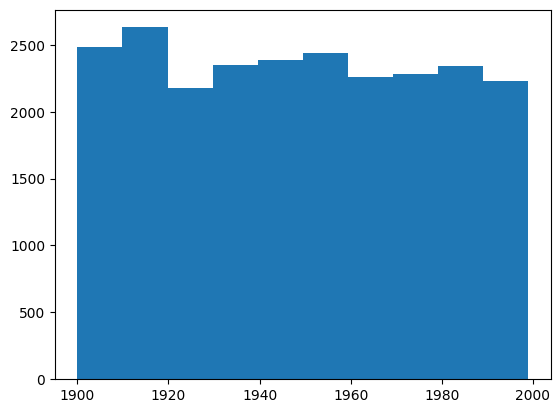

In [ ]:
# Vérifier si les années ont la même distribution pour créer des blocs
plt.hist(df["year_of_birth"])
plt.show()

Intervalle des numéros de sécurité sociale: de 1000123 a 9996479


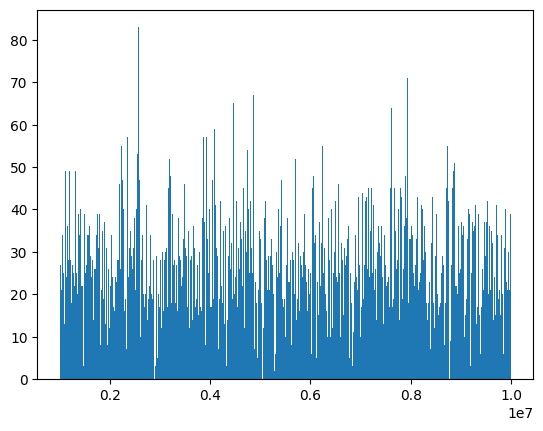

In [ ]:
# Vérifier l'intervalle des numéros de sécurité sociale et la distribution
min_soc_sec = min(df['soc_sec_id'])
max_soc_sec = max(df['soc_sec_id'])
print(f'Intervalle des numéros de sécurité sociale: de {min_soc_sec} a {max_soc_sec }')

plt.hist(df['soc_sec_id'], bins=900)
plt.show()

###Définition de la méthode de détection des doublons 

Lors de la définition de la règle à utiliser pour détecter les enregistrements dupliqués, nous nous sommes demandé quelle était la méthode la plus appropriée selon la nature des attributs.

**Edit distance metric est basé sur la comparaison de chaines de charactères, ce qui est bien adapté pour des noms, prénoms, dénominations** ou liste de 'chiffres' mais ne l'est pas pour des **adresses qui sont des blocs / tokens séparés par des espaces  et pour lesquels 'Jaccard Distance'** convient mieux. En revanche dans notre cas, les adresses comprenent un token voire 2 de taille très variable. Rajouter un découpage par 'n-gram' sur les lettres ou sur les 'tokens' ne nous semblent pas utile.


Concernant le choix des attributs à priviliger, il nous a semblé qu'une combinaison de trois attributs parmi nom ('surname'),prénom ('given_name'),état ('state'),code postal ('postcode) et 'soc_sec_id' était un bon compromis. Le choix 3 attributs réduisant les risques d'erreur (faux positif)... certains attributs ciblant plus directement une personne et d'autres étant "juste" disponibles. Nous avons choisi la **Levenshtein edit-distance** pour la raison invoquée précédemment. 

Compte-tenu du nombre de cellules vides, il ne sera pas possible dans certains cas, d'avoir 3 de ces critères simultanément. Dans ces cas, nous utiliserons les adresses et l'attribut 'suburb' dont les distances seront évaluées avec la **Jaccard distance** (sans n-gram et tokenisation).

Nous utiliserons la librairie NLTK (Natural Language Toolkit) pour le traitement symbolique et statistique du langage naturel.

A noter que le choix de 3 attributs aura un impact les temps d'exécution tout en restant dans le raisonnable (grâce au blocking). C'est un choix assumé car nous priviligions la qualité et l'exhaustivité des détections.

### Matrice de confusion
Nous avions espéré pouvoir mettre en place une métric d'évaluation de notre modèle avec la création d'une matrice de confusion. 

Pour faire cela, l'attribut 'soc_sec_id' nous semblait idéal (à la fois complet et lorsque correctement saisi, unique par personne). 

Nous avons cependant constaté que ce champ n'était pas unique par personne (cf. paragraphe initial d'exploration des données où l'on montre des exemples de personnes uniques avec plusieurs valeurs) ce qui le rendait impropre à la création d'une matrice de confusion.

NB : l'attribut id record n'est pas utilisable car il identifie les enregistrements et non les personnes

## Models de détection des doublons
Dans cette partie, nous présenterons deux modèles différents basés sur la méthodologie et l'approche décrites ci-dessus et que nous comparerons selon deux critères : maximisation du nombre de lignes analysées (capacité à trouver une méthode pour conserver les lignes avec des cellules à "Na") et rapidité d'exécution.

Nous appliquerons un algorithme itératif à chaque bloc qui prend chaque combinaison d'enregistrements dans le bloc et si la paire correspond à la règle définie, elle est enregistrée comme (record_id1, record_id1) dans la liste "matches".

Pour rappel, dans nos modèles, nous avons considéré que trois attributs étaient un bon compromis en terme d'efficacité versus rapiditié afin de détecter les doublons tout en réduisant les risque d'homonymies et le nombre de faux positifs.

### Model 1 basé sur l'utilisation de **3 attributs et la gestion des exceptions dans Pyhton** 

Nous avons pris les attributs 'PostCode' et 'Soc_sec_id' qui présentent l'avantage d'être toujours renseignés (mais parfois avec des erreurs de saisies) et un attribut pris au choix parmi "Surname ou Given_Name ou State" selon que les valeurs sont renseignées ou non (grâce à la  **gestion des exceptions**), afin de préserver autant que possible le nombre  d'enregistrements analysés.

Cet modèle comprend deux parties :
La 1iere partie utilise **edit distance** sur les attributs qui s'y prêtent bien (surname,givename,state,postcode).

La 2ieme partie se focalise sur les lignes qui n'ont pas pues être traitées dans la 1iere partie (suite au retrait des lignes avec des cellules à 'na') et utilise **jaccard distance** sur les attributs adresse (1 & 2) et suburb.



In [ ]:
#calcul du nombre de lignes non prises en compte par cet algorithme

df_etudiants_clean=df.dropna(subset=['given_name']).dropna(subset=['surname']).dropna(subset=['state']).dropna(subset=['date_of_birth'])
df_etudiants_solde=pd.concat([df,df_etudiants_clean]).drop_duplicates(keep=False)

In [ ]:
#cette partie va pouvoir parcourir 21 485 enregistrements
df.count()-df_etudiants_solde.count()

given_name       21485
surname          21485
street_number    20320
address_1        20561
address_2        17777
suburb           21035
postcode         21485
state            21485
date_of_birth    21485
soc_sec_id       21485
id record        21485
year_of_birth    21485
dtype: int64

partie 1 : détection des doublons sur les attributs pour lesquels Edit Distance est adapté

In [ ]:
#préparation des blocks sur la base des années renseignées
df_prep=df.dropna(subset=['year_of_birth']) #ici choix de supprimer les années à "Na"
#contrôle
#df_prep[df_prep['year_of_birth'].isna()].sum()
list_year=list(df_prep.groupby('year_of_birth')['year_of_birth'].unique())
blocks = []
for i in list_year:
    blocks.append(df.loc[df['year_of_birth'] == i[0]])

In [ ]:
#df.columns # vérification des indices des colonnes

Index(['given_name', 'surname', 'street_number', 'address_1', 'address_2',
       'suburb', 'postcode', 'state', 'date_of_birth', 'soc_sec_id',
       'id record', 'year_of_birth'],
      dtype='object')

In [ ]:
#corps principal avec recherche de doublons sur 3 critères suivants : postcode & socscid et (surname ou givenname ou state)
#partant du principe que 3 critères satisfaits réduisent fortement le risque d'homonymie

matches = []
number_of_matches = 0
start = time.process_time()

for block in blocks:
    num_records = len(block)
    print("num_records of the block is {} et année is {} ".format(num_records,block.iloc[0,11])) #year_of_birth #11
    for i in range(0,num_records):
         for j in range(i+1,num_records): 
            score_postcode=nltk.edit_distance(str(block.iloc[i,6]), str(block.iloc[j,6])) #postcode #6
            score_socsecid=nltk.edit_distance(str(block.iloc[i,9]), str(block.iloc[j,9]))  #soc_sec_id #9
            try:
                score_surname = nltk.edit_distance(block.iloc[i,1], block.iloc[j,1])  #surname #1
                if (score_postcode <= 2) and (score_socsecid <= 2) and (score_surname <= 2):
                    number_of_matches = number_of_matches +1 
                    matches.append((block.iloc[i,10],block.iloc[j,10])) #od record #10
            except(TypeError):
                try:
                    score_givenname = nltk.edit_distance(block.iloc[i,0], block.iloc[j,0]) #givename #0
                    if (score_givenname <= 2) and (score_postcode <= 2) and (score_socsecid <= 2):
                        number_of_matches = number_of_matches +1 
                        matches.append((block.iloc[i,10],block.iloc[j,10]))
                except(TypeError):
                    try:
                        score_state = nltk.edit_distance(block.iloc[i,7], block.iloc[j,7]) #state #7
                        if (score_state <= 2) and (score_postcode <= 2) and (score_socsecid <= 2):
                            number_of_matches = number_of_matches +1 
                            matches.append((block.iloc[i,10],block.iloc[j,10]))
                    except(TypeError):
                        pass

end = time.process_time()

print("Number of matches: {}".format(number_of_matches))
print("Processing time: {}".format(end - start))  

num_records of the block is 287 et année is 1900.0 
num_records of the block is 240 et année is 1901.0 
num_records of the block is 277 et année is 1902.0 
num_records of the block is 298 et année is 1903.0 
num_records of the block is 232 et année is 1904.0 
num_records of the block is 235 et année is 1905.0 
num_records of the block is 250 et année is 1906.0 
num_records of the block is 168 et année is 1907.0 
num_records of the block is 214 et année is 1908.0 
num_records of the block is 280 et année is 1909.0 
num_records of the block is 261 et année is 1910.0 
num_records of the block is 244 et année is 1911.0 
num_records of the block is 259 et année is 1912.0 
num_records of the block is 297 et année is 1913.0 
num_records of the block is 261 et année is 1914.0 
num_records of the block is 272 et année is 1915.0 
num_records of the block is 282 et année is 1916.0 
num_records of the block is 282 et année is 1917.0 
num_records of the block is 281 et année is 1918.0 
num_records 

In [ ]:
# Display results 
#sur 21 485 enregistrements, 56 452 combinaisons possibles de doublons ont été identifiées
#l'écart entre les 56K et le nombre d'enregistrement, s'explique par le fait qu'un même enregistrement peut être 
#comptabilisé par tous les matchs possibles de 'record id' le précédant dans le bloc
for match in matches:
    print("The following records {} and {} match".format(match[0],match[1]))
    print("The persons with the following names {} and {} match.".format(df_prep.loc[df_prep['id record'] == match[0]]['surname'].values[0],df_prep.loc[df_prep['id record'] == match[1]]['surname'].values[0]))
    print("The persons with the following soc_id {} and {} match.".format(df_prep.loc[df_prep['id record'] == match[0]]['soc_sec_id'].values[0],df_prep.loc[df_prep['id record'] == match[1]]['soc_sec_id'].values[0]))
    print("\n")

partie 2 : détection des doublons sur les lignes qui n'ont pu être analysées dan la 1iere partie et utilisation de Jaccard Distance sur les attributs adress1, address2 et suburb

In [ ]:
#suite analyse sur les lignes qui n'ont pas été prises en compte dans la 1iere phase
df_prep=df.dropna(subset=['surname']).dropna(subset=['given_name']).dropna(subset=['state']).dropna(subset=['year_of_birth'])

#création d'un DF avec les lignes non utilisées précédemment
df_etudiants_solde=pd.concat([df,df_prep]).drop_duplicates(keep=False)

In [ ]:
#contrôle pour s'assurer que l'on retrouve bien le nombre initial d'enregistrements
21485+3455 

24940

In [ ]:
#nombre de ligne que cette partie va vraiement traiter
#suite analyse sur les lignes qui n'ont pas été prises en compte dans la 1iere phase
df_prep=df_etudiants_solde.dropna(subset=['address_1']).dropna(subset=['address_2']).dropna(subset=['suburb'])

#création d'un DF avec les lignes non utilisées précédemment
df_etudiants_solde_résidut=pd.concat([df_etudiants_solde,df_prep]).drop_duplicates(keep=False)

In [ ]:
#cette approche permet d'analyse 2714 enregistrements (sur 3455)
df_etudiants_solde.count()-df_etudiants_solde_résidut.count()

group_soc_id     2714
given_name       1747
surname          2286
street_number    2463
address_1        2714
address_2        2714
suburb           2714
postcode         2714
state            2352
date_of_birth    1627
soc_sec_id       2714
id record        2714
year_of_birth    1627
dtype: int64

In [ ]:
#En prévision de la méthode de blocking sur cette partie, nous allons séparer les enregistrements sur la base des soc_id
#il est en effet probable (en tout cas constaté sur quelques exemples) que les erreurs de saisie de soc id concernent les unités,dizaines  et non les centaines voire les milliers
#cette approche nous permet de maximiser au sein d'un même bloc, les potentiels doublons

df_etudiants_solde.insert(0,"group_soc_id",(df_etudiants_solde['soc_sec_id']//1e3).astype(int))

In [ ]:
#et il faut d'abord trier pour assurer le regroupement des potentiels doublons au sein d'un bloc
df_etudiants_solde.sort_values(['group_soc_id'],inplace=True,ignore_index=True)

In [ ]:
#création des blocs sur la base des soc_sec_id 
#ici on a choisi de faire 20 blocs, pour réduire chaque bloc à une centaine d'enregistrement
#c'est un choix arbitraire / 100 nous semblant une taille 'maitrisable'
#ce qui permet d'accepter des erreurs de saisie sur les unités et les dizaines
k=20
num_val_samples = len(df_etudiants_solde) // k 
blocks_solde=[]

for i in range(k):
    print('processing fold #', i)
    blocks_solde.append(df_etudiants_solde[i * num_val_samples: (i + 1) * num_val_samples]) #slicing 
blocks_solde.append(df_etudiants_solde[(i+1) * num_val_samples: len(df_etudiants_solde)])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
processing fold # 11
processing fold # 12
processing fold # 13
processing fold # 14
processing fold # 15
processing fold # 16
processing fold # 17
processing fold # 18
processing fold # 19


In [ ]:
#vérification des indices des colonnes
df_etudiants_solde.columns

Index(['group_soc_id', 'given_name', 'surname', 'street_number', 'address_1',
       'address_2', 'suburb', 'postcode', 'state', 'date_of_birth',
       'soc_sec_id', 'id record', 'year_of_birth'],
      dtype='object')

In [ ]:
#corps principal de la 2ieme partie 
#avec recherche de doublon sur 3 critères 
#toujours edit distance sur postcode et soc sec id
#mais jaccard distance sur l'un des trois attributs présents (adress_1,adress_2 ou suburb)
#choix d'une distance jaccard de 0.3, mais qui semble donner des bons résultats sur quelques exemples
#difficile d'apprécier la pertinence de cette valeur de façon systématique sans matrice de confusion

matches_solde = []
number_of_matches_solde = 0
start = time.process_time()

for block in blocks_solde:
    num_records = len(block)
    print("num_records of the block is {} et bloc soc_id is {} ".format(num_records,block.iloc[0,0])) #block soc Id # 0
    for i in range(0,num_records):
         for j in range(i+1,num_records): 
            score_postcode=nltk.edit_distance(str(block.iloc[i,7]), str(block.iloc[j,7])) #postcode #7
            score_socsecid=nltk.edit_distance(str(block.iloc[i,10]), str(block.iloc[j,10]))  #soc_sec_id #10
            try:
                score_address1 = nltk.jaccard_distance(set(block.iloc[i,4]),set(block.iloc[j,4]))  #adress1 #4
                if (score_postcode <= 2) and (score_socsecid <= 2) and (score_address1 <= 0.3):
                    number_of_matches_solde = number_of_matches_solde +1 
                    matches_solde.append((block.iloc[i,11],block.iloc[j,11])) #id record #11
            except(TypeError):
                try:
                    score_address2 = nltk.jaccard_distance(set(block.iloc[i,5]),set(block.iloc[j,5]))  #adresse2 #5
                    if (score_address2 <= 0.3) and (score_postcode <= 2) and (score_socsecid <= 2):
                        number_of_matches_solde = number_of_matches_solde +1 
                        matches_solde.append((block.iloc[i,11],block.iloc[j,11]))
                except(TypeError):
                    try:
                        score_suburb = nltk.jaccard_distance(set(block.iloc[i,6]),set(block.iloc[j,6])) #suburb #6
                        if (score_suburb <= 2) and (score_postcode <= 2) and (score_socsecid <= 2):
                            number_of_matches_solde = number_of_matches_solde +1 
                            matches_solde.append((block.iloc[i,11],block.iloc[j,11]))
                    except(TypeError):
                        pass

end = time.process_time()

print("Number of matches: {}".format(number_of_matches_solde))
print("Processing time: {}".format(end - start))  

num_records of the block is 172 et bloc soc_id is 1015 
num_records of the block is 172 et bloc soc_id is 1525 
num_records of the block is 172 et bloc soc_id is 2066 
num_records of the block is 172 et bloc soc_id is 2382 
num_records of the block is 172 et bloc soc_id is 2866 
num_records of the block is 172 et bloc soc_id is 3352 
num_records of the block is 172 et bloc soc_id is 3707 
num_records of the block is 172 et bloc soc_id is 4169 
num_records of the block is 172 et bloc soc_id is 4646 
num_records of the block is 172 et bloc soc_id is 5094 
num_records of the block is 172 et bloc soc_id is 5540 
num_records of the block is 172 et bloc soc_id is 5932 
num_records of the block is 172 et bloc soc_id is 6490 
num_records of the block is 172 et bloc soc_id is 6972 
num_records of the block is 172 et bloc soc_id is 7289 
num_records of the block is 172 et bloc soc_id is 7724 
num_records of the block is 172 et bloc soc_id is 8217 
num_records of the block is 172 et bloc soc_id i

In [ ]:
# Display results 
#sur 2 714 enregistrements, 8 196 combinaisons possibles de doublons ont été identifiées
for match in matches_solde:
    print("The following records {} and {} match".format(match[0],match[1]))
    print("The persons with the following names {} and {} match.".format(df_etudiants_solde.loc[df_etudiants_solde['id record'] == match[0]]['surname'].values[0],df_etudiants_solde.loc[df_etudiants_solde['id record'] == match[1]]['surname'].values[0]))
    print("The persons with the following soc_id {} and {} match.".format(df_etudiants_solde.loc[df_etudiants_solde['id record'] == match[0]]['soc_sec_id'].values[0],df_etudiants_solde.loc[df_etudiants_solde['id record'] == match[1]]['soc_sec_id'].values[0]))
    print("\n")

In [ ]:
#dernière partie concatenation des deux listes matches et matches_solde 
resultat_modele_1=matches+matches_solde


### Model 2: basé sur numéro de sécurité sociale comme méthode de blocage

Nous testerons également un deuxième modèle qui présente les caractéristiques suivantes :
- une méthode de blocage basée sur le numéro de sécurité sociale
- un algorithme de détection des doublons en 4 parties:
  
  1. Si le prénom et le nom existent, on applique une condition sur la valeur de l'edit distance du nom, prénom et numéro de sécurité sociale;
  2. Si le prénom n'existe pas mais le nom existe, on applique une condition valeur de l'edit distance du nom et même numéro de sécurité sociale et année de naissance;
  3. Si le prénom existe mais le nom n'existent pas, on applique une condition sur le fait d'avoir le meme prénom, numéro de sécurité sociale et année de naissance 
  4. Si ni le prénom ni le nom n'existent pas, on applique une condition sur le fait d'avoir le meme numéro de sécurité sociale, date de naissance et code postal

  Les conditions sont d'autant plus strictes que le nombre d'arguments est nul, afin d'éviter les faux positifs.

In [ ]:
# Création d'une liste de chiffres pour créer des intervalles afin de decouper la base de données en blocs
list_soc_num_range = []
list_soc_num_range = [i for i in range(1_000_000,10_010_000, 10_000)]
print(len(list_soc_num_range))
print(min(list_soc_num_range))
print(max(list_soc_num_range))

901
1000000
10000000


In [ ]:
# Création de la liste de blocs
# Ce decoupage permettra de regrouper les numéros de sécurité sociale dont les 3 premiers chiffres sont identiques 
blocks_soc_sec = []
for i in range(0, len(list_soc_num_range)-1):
  block = df[((df['soc_sec_id'] >= list_soc_num_range[i]) & (df['soc_sec_id'] < list_soc_num_range[i+1]))]
  blocks_soc_sec.append(block)
# Vérifier le numero de blocs
print("Numero de blocs:")
print(len(blocks_soc_sec))
# Exemple d'intervalle de numéros de sécurité sociale dans le même bloc (meme trois premiers chiffres)
print("Exemple d'intervalle de numéros de sécurité sociale dans le même bloc:")
print(min(blocks_soc_sec[5]['soc_sec_id']))
print(max(blocks_soc_sec[5]['soc_sec_id']))

Numero de blocs:
900
Exemple d'intervalle de numéros de sécurité sociale dans le même bloc:
1050753
1057227


In [ ]:
# Vérifier que l'ensemble de bloc constitue le dataframe entier
count_test = 0
for block in blocks_soc_sec:
  count_test += len(block)
print(count_test)

24940


In [ ]:
# Vérifier la longueur de chaque bloc
block_len_list = []
for i in blocks_soc_sec:
  block_len_list.append(len(i))
print(min(block_len_list))
print(max(block_len_list))
# => Il y a des blocs vides

0
85


In [ ]:
# Vérifier les indices des blocs vides
list_index_empty_block = []
for i in range(0, len(blocks_soc_sec)):
  if len(blocks_soc_sec[i]) <= 1:
    list_index_empty_block.append(i)
print(list_index_empty_block)
print(f'Numero de blocs vides: {len(list_index_empty_block)}')
# => Nous devrons traiter le cas des blocs vides dans notre algorithme

[188, 404, 660]
Numero de blocs vides: 3


In [ ]:
# Vérifier le comportement de la comparaison booléenne lorsque j'ai deux valeurs nulles pour l'année de naissance
year_null_1 = df[df['year_of_birth'].isnull()]['date_of_birth'][23] 
year_null_2 = df[df['year_of_birth'].isnull()]['date_of_birth'][30] 
print(f'Le resultat de {year_null_1} == {year_null_2 } est {year_null_1 == year_null_2 }')

Le resultat de NaT == NaT est False


In [ ]:
matches_2 = []
number_of_matches_2 = 0
start_2 = time.process_time()

for block in blocks_soc_sec:
  if len(block) > 1: # Je souhaite traiter uniquement les blocs contenant au moins 2 enregistrements

    num_records = len(block)
    for i in range(0, num_records):
        for j in range(i+1, num_records):

            # (1) Si le prenom (index 0) et le nom (index 1) existent:
            if pd.notnull(block.iloc[i,0]) and pd.notnull(block.iloc[j,0]) and pd.notnull(block.iloc[i,1]) and pd.notnull(block.iloc[j,1]):
                # Calcul de l'edit distance du nom, prénom et numéro de sécurité sociale (index 9)
                name_score = nltk.edit_distance(block.iloc[i,0], block.iloc[j,0])
                surname_score = nltk.edit_distance(block.iloc[i,1], block.iloc[j,1])
                soc_sec_score = nltk.edit_distance(str(block.iloc[i,9]), str(block.iloc[j,9]))
                # Condition sur la valeur de l'edit distance du nom, prénom et numéro de sécurité sociale
                # Si la condition de score est remplie, le nombre de correspondances est incrémenté d'une unité et l’enregistrement est ajoutée a la variable matches_2
                if (name_score <= 2) and (surname_score <= 2) and (soc_sec_score <= 2):
                    number_of_matches_2 = number_of_matches_2 + 1 
                    matches_2.append((block.iloc[i,10],block.iloc[j,10])) #10 is the index for 'id record'

            # (2) Si le prenom (index 0) n'existe pas et le nom (index 1) existe:
            elif pd.isnull(block.iloc[i,0]) and pd.isnull(block.iloc[j,0]) and pd.notnull(block.iloc[i,1]) and pd.notnull(block.iloc[j,1]):
                # Calcul de l'edit distance du nom
                surname_score = nltk.edit_distance(block.iloc[i,1], block.iloc[j,1])
                # Condition sur la valeur de l'edit distance du nom, meme numéro de sécurité sociale et meme année de naissance 
                if (surname_score <= 2) and (block.iloc[i,9] == block.iloc[j,9]) and (block.iloc[i,11] == block.iloc[j,11]):
                    number_of_matches_2 = number_of_matches_2 + 1 
                    matches_2.append((block.iloc[i,10],block.iloc[j,10])) 

            # (3) Si le prenom (index 0) existe et le nom (index 1) n'existe pas:
            elif pd.notnull(block.iloc[i,0]) and pd.notnull(block.iloc[j,0]) and pd.isnull(block.iloc[i,1]) and pd.isnull(block.iloc[j,1]):
                # Condition sur le fait d'avoir le meme prénom, numéro de sécurité sociale et année de naissance 
                if (block.iloc[i,0] == block.iloc[j,0]) and (block.iloc[i,9] == block.iloc[j,9]) and (block.iloc[i,11] == block.iloc[j,11]) :
                    number_of_matches_2 = number_of_matches_2 + 1 
                    matches_2.append((block.iloc[i,10],block.iloc[j,10])) 

            # (4) Si prenom (index 0) et nom (index 1) n'existe pas:
            elif pd.isnull(block.iloc[i,0]) and pd.isnull(block.iloc[j,0]) and pd.isnull(block.iloc[i,1]) and pd.isnull(block.iloc[j,1]):
                # Condition sur le fait d'avoir le meme numéro de sécurité sociale, date de naissance et code postal
                if (block.iloc[i,9] == block.iloc[j,9]) and (block.iloc[i,8] == block.iloc[j,8]) and (block.iloc[i,6] == block.iloc[j,6]):
                  number_of_matches_2 = number_of_matches_2 + 1 
                  matches_2.append((block.iloc[i,10],block.iloc[j,10])) 


end_2 = time.process_time()
print("Number of matches: {}".format(number_of_matches_2))
print("Processing time (s): {}".format(end_2 - start_2))  

Number of matches: 59490
Processing time (s): 129.108988889


In [ ]:
# Montrer quelques exemples de correspondances
for match in matches_2[:10]:
    print("The following records {} and {} match".format(match[0],match[1]))
    print("The persons with the following surnames {} and {} match.".format(df.loc[df['id record'] == match[0]]['surname'].values[0],df.loc[df['id record'] == match[1]]['surname'].values[0]))
    print("The persons with the following date of birth {} and {} match.".format(df.loc[df['id record'] == match[0]]['date_of_birth'].values[0],df.loc[df['id record'] == match[1]]['date_of_birth'].values[0]))
    print("The persons with the following soc_id {} and {} match.".format(df.loc[df['id record'] == match[0]]['soc_sec_id'].values[0],df.loc[df['id record'] == match[1]]['soc_sec_id'].values[0]))
    print("\n")

The following records B_351 and B_3116 match
The persons with the following surnames clarke and clarke match.
The persons with the following date of birth 1963-07-30 and 1963-07-30 match.
The persons with the following soc_id 1009287 and 1009287 match.


The following records B_351 and B_11630 match
The persons with the following surnames clarke and clarke match.
The persons with the following date of birth 1963-07-30 and 1963-07-30 match.
The persons with the following soc_id 1009287 and 1009287 match.


The following records B_351 and B_18713 match
The persons with the following surnames clarke and clarke match.
The persons with the following date of birth 1963-07-30 and 1963-07-30 match.
The persons with the following soc_id 1009287 and 1009287 match.


The following records B_351 and B_19027 match
The persons with the following surnames clarke and clarke match.
The persons with the following date of birth 1963-07-30 and 1963-07-30 match.
The persons with the following soc_id 100928


## Conclusion

En conclusion, nous avons développé 2 méthodes, avec deux attributs différents pour la définition du blocage : une approche hybride basée principalement sur l'année (méthode 1) et une approche exclusivement basée sur le numéro de sécurité sociale (méthode 2).

Concernant **la méthode 1**:
- celle-ci a permis de traiter 24 199  (21 485 + 2714) enregistrements sur les 24 940 soit 97%; ce qui est un beau score compte-tenu du nombre d'enregistrements contenant au moins une cellule nulle (~1/3). 
- Cette méthode indique avoir trouvé 64 648 (56 452 + 8 196) pairs d'ID Record correspondant à des duplicates (à travers un mix d'edit distance et jaccard distance). 
Malheureusement il n'y a pas de méthode systèmatique pour évaluer la justesse de cette méthode.
- Le temps d'exécution de la première partie a été de 860 sc (en mode GPU sous Google Colab) et de 88 sc sur la 2ieme partie. Clairement le choix de maximiser le nombre de lignes à analyser à impacter le temps d'exécution.
- l'utilisation des exceptions combinée à l'utilisation de edit distance ou jaccard distance selon le type d'attribut nous a permis d'utiliser tous les attributs à l'exception du numéro de l'adresse. Nous avons choisi de ne pas l'utiliser,  car cet attribut nous semblait particulièrement peu fiable et sans disposer d'une métric adaptée pour comparer deux chiffres (comment mesurer la distance entre 0 et 8 plutôt qu'entre 0 et 5 ?).

Concernant **la méthode 2**:
- celle-ci a permis de traiter tous les enregistrements à l'exception des cas où l'année n'est pas renseignée (soit 1008 enregistrements) ;
- Cette méthode indique avoir trouvé 59 490 pairs d'ID Record correspondant à des duplicates (à travers un mix d'edit distance et d'égalités). 
- Le temps d'exécution a été de 129 secondes (en mode GPU sous Google Colab).

En comparant les deux méthodes, les deux méthodes s'approchent des 97% d'enregistrements traités, mais la première est  nettement moins rapide... 

Concernant l'efficacité à trouver les doublons,malheureusement il n'y a pas de méthode systèmatique pour évaluer la justesse d'une méthode par rapport à une autre afin par example comparer la précision et la pourcentage de faux positifs, faute d'avoir trouvé d'attribut précis qui corresponde à cet objectif (mais c'est probablement un cas courant dans des situations opérationnelles).